In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
full_db = '/Volumes/KenDrive/lhd_testing/merged_sites.xlsx'
flowline_sources = ['NHD', 'TDX']
streamflow_sources = ['NWM', 'GEO']

# 1. Read Sites and Filter
sites_df = pd.read_excel(full_db, sheet_name='Sites')
sites_clean = sites_df[sites_df['comments'].isna()]

# List to store stats for plotting
plot_data = []

for flowline in flowline_sources:
    for streamflow in streamflow_sources:
        # Read in the hydraulic results
        sheet_name = f'Results{flowline}{streamflow}'
        results_df = pd.read_excel(full_db, sheet_name=sheet_name)

        # Filter to good sites
        results_sites = results_df[results_df['site_id'].isin(sites_clean['site_id'])]

        # Filter out bad dam height predictions (Use results_sites, not results_df!)
        results_valid = results_sites.dropna(subset=['jump_type'])

        total_valid = len(results_valid)
        combo_label = f"{flowline}-{streamflow}"

        print(f'Processing {combo_label} ({total_valid} valid results)...')

        for i in range(1, 5):
            xs_i = results_valid[results_valid['xs_index'] == i]
            valid_i = len(xs_i)

            # Avoid division by zero
            if valid_i == 0:
                continue

            # Calculate Counts
            # (Using the corrected boolean summing method)
            type_a = (xs_i['jump_type'] == 'A').sum()
            type_c = (xs_i['jump_type'] == 'C').sum()
            type_d = (xs_i['jump_type'] == 'D').sum()

            # Store data for plotting (focusing on A, C, D)
            plot_data.append({'Combination': combo_label, 'xs_index': i, 'jump_type': 'Type A', 'percentage': (type_a / valid_i * 100)})
            plot_data.append({'Combination': combo_label, 'xs_index': i, 'jump_type': 'Type C', 'percentage': (type_c / valid_i * 100)})
            plot_data.append({'Combination': combo_label, 'xs_index': i, 'jump_type': 'Type D', 'percentage': (type_d / valid_i * 100)})


Processing NHD-NWM (1127 valid results)...
Processing NHD-GEO (920 valid results)...
Processing TDX-NWM (760 valid results)...
Processing TDX-GEO (1239 valid results)...


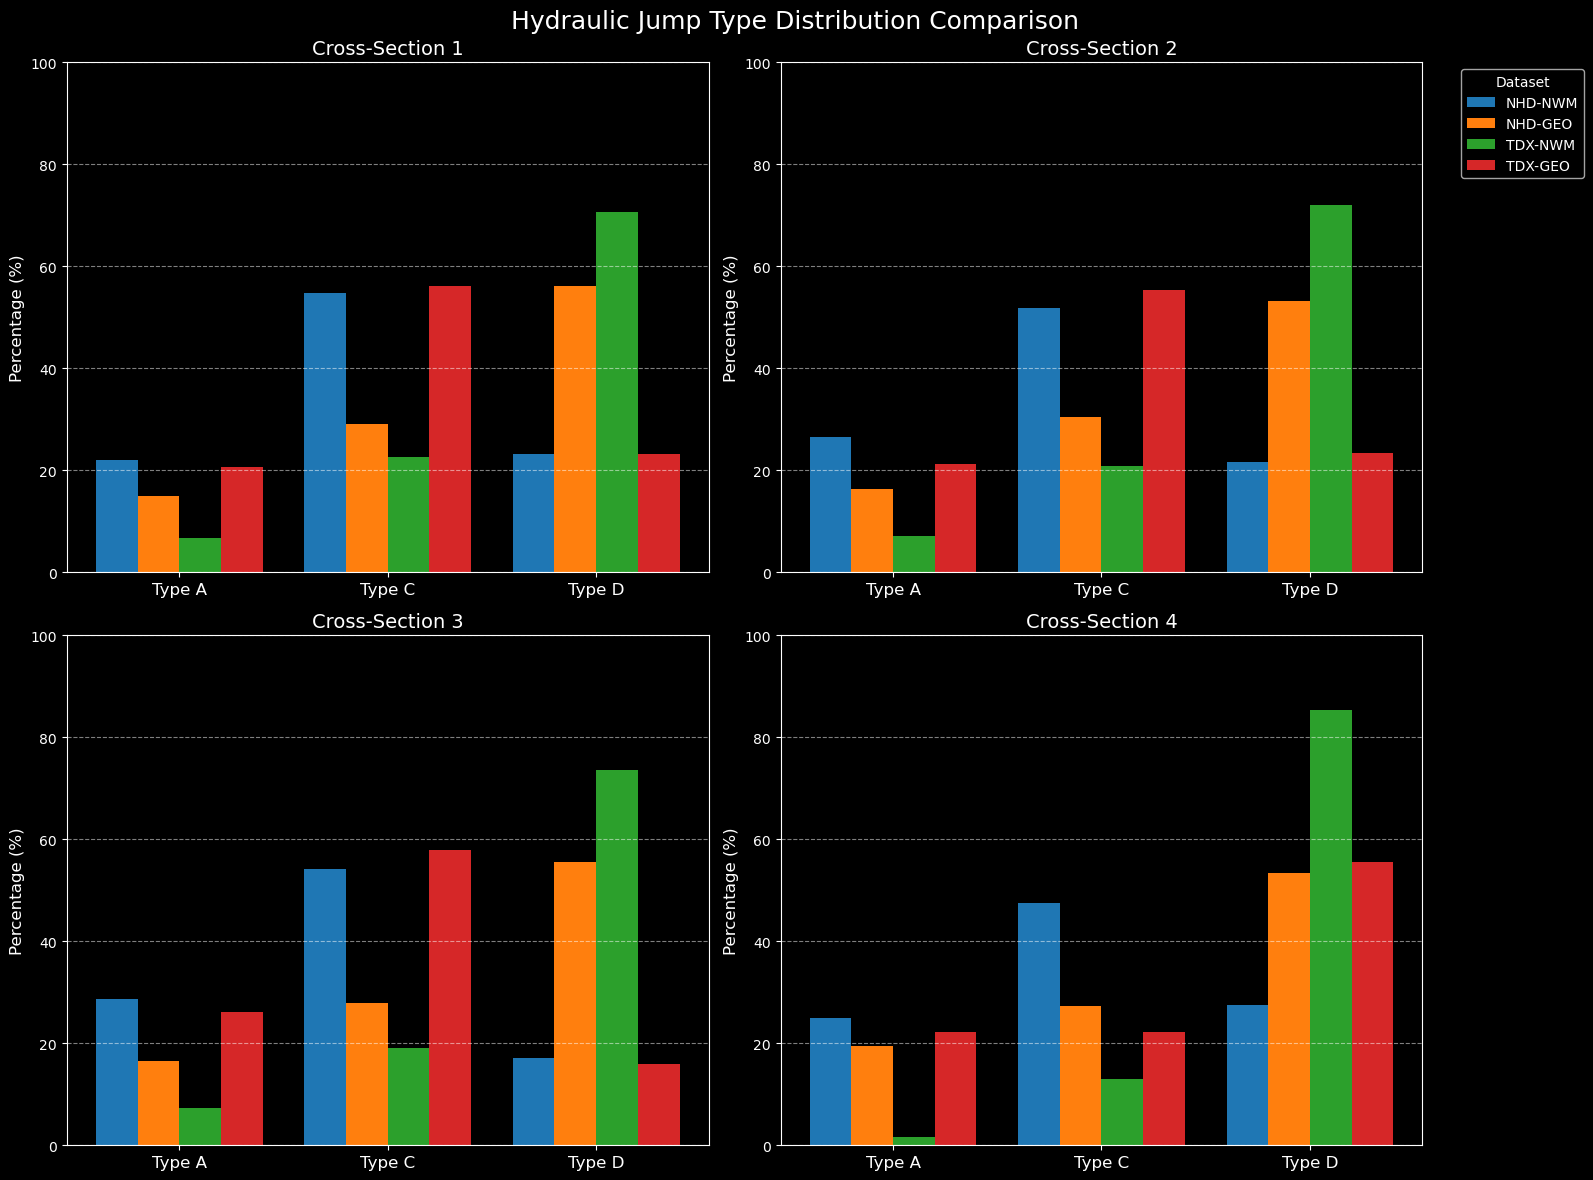

In [3]:
# --- PLOTTING ---
df_plot = pd.DataFrame(plot_data)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

jump_types = ['Type A', 'Type C', 'Type D']
combinations = df_plot['Combination'].unique()
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'] # Blue, Orange, Green, Red
bar_width = 0.2
x = np.arange(len(jump_types))

for i, xs in enumerate(range(1, 5)):
    ax = axes[i]
    subset_xs = df_plot[df_plot['xs_index'] == xs]

    for j, combo in enumerate(combinations):
        subset_combo = subset_xs[subset_xs['Combination'] == combo]

        # Extract heights in strict order
        heights = []
        for jt in jump_types:
            row = subset_combo[subset_combo['jump_type'] == jt]
            heights.append(row['percentage'].values[0] if not row.empty else 0)

        # Center bars around the tick
        pos = x + (j - 1.5) * bar_width
        ax.bar(pos, heights, bar_width, label=combo, color=colors[j])

    ax.set_title(f'Cross-Section {xs}', fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels(jump_types, fontsize=12)
    ax.set_ylabel('Percentage (%)', fontsize=12)
    ax.set_ylim(0, 100)
    ax.grid(axis='y', linestyle='--', alpha=0.5)

    if i == 1:
        ax.legend(title='Dataset', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.suptitle('Hydraulic Jump Type Distribution Comparison', fontsize=18)
plt.tight_layout()
plt.show()

# Automated Cross-Section Plotting for LHD Results
This notebook iterates through a specified results directory, loads the Cross-Section (XS) geometries, and generates plots for each LHD ID found.

In [34]:
import os
import ast
import pyproj
import geopandas as gpd

# Set the PROJ_LIB variable to the path found by pyproj
proj_path = pyproj.datadir.get_data_dir()
os.environ['PROJ_LIB'] = proj_path
# print(f"PROJ_LIB set to: {proj_path}")

## 1. Configuration
Set the path to your results directory here.

In [31]:
# UPDATE THIS PATH to your actual results directory
RESULTS_DIR = '/Volumes/KenDrive/lhd_testing/Results_nhd_nwm'
# OUTPUT_DIR can be the same as RESULTS_DIR or a separate folder for organized plots
OUTPUT_PLOT_DIR = os.path.join(RESULTS_DIR, '_All_Plots')

if not os.path.exists(OUTPUT_PLOT_DIR):
    os.makedirs(OUTPUT_PLOT_DIR)

print(f"Reading results from: {RESULTS_DIR}")
print(f"Saving combined plots to: {OUTPUT_PLOT_DIR}")

Reading results from: /Volumes/KenDrive/lhd_testing/Results_nhd_nwm
Saving combined plots to: /Volumes/KenDrive/lhd_testing/Results_nhd_nwm/_All_Plots


## 2. Define Plotting Function
This function is adapted from `lhd_processor/analysis/figures.py`.
It takes the GeoDataFrame containing XS profiles and plots them.

In [36]:
def plot_cross_sections(combined_gdf, lhd_id, save_dir):
    """
    Plots cross-sections from the provided GeoDataFrame.

    Args:
        combined_gdf (GeoDataFrame): GDF containing 'XS1_Profile', 'XS2_Profile', 'Ordinate_Dist'.
        lhd_id (str): The ID of the LHD/Site.
        save_dir (str): Directory to save the resulting plot.
    """
    cmap = plt.cm.viridis
    norm = plt.Normalize(vmin=0, vmax=len(combined_gdf) - 1)

    plt.figure(figsize=(10, 6))

    # Iterate through each cross-section in the file
    for i in range(len(combined_gdf)):
        # Extract profile arrays
        y_1 = combined_gdf['XS1_Profile'].iloc[i]
        y_2 = combined_gdf['XS2_Profile'].iloc[i]

        # Calculate lateral distances (X coordinates)
        # XS1 extends negative, XS2 extends positive
        dist = ast.literal_eval(combined_gdf['Ordinate_Dist'].iloc[i])
        x_1 = [0 - j * dist for j in range(len(y_1))]
        x_2 = [0 + j * dist for j in range(len(y_2))]

        # Filter out invalid data (threshold from original script)
        INVALID_THRESHOLD = -1e5

        # Combine Left (XS1) and Right (XS2) banks
        # Note: XS1 is usually stored starting from center, so we reverse it for plotting
        x = x_1[::-1] + x_2
        y = y_1[::-1] + y_2

        x_clean = []
        y_clean = []
        for xi, yi in zip(x, y):
            if yi > INVALID_THRESHOLD:
                x_clean.append(xi)
                y_clean.append(yi)

        color = cmap(norm(i))
        label = f'Downstream XS {i}' if i > 0 else 'Upstream XS'
        plt.plot(x_clean, y_clean, label=label, color=color, alpha=0.7)

    plt.title(f'Reach Cross-Sections at LHD No. {lhd_id}')
    plt.legend(title="Cross-Sections", loc='best', fontsize='small', bbox_to_anchor=(1.05, 1))
    plt.ylabel('Elevation (m)')
    plt.xlabel('Lateral Distance (m)')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()

    # Save plot
    png_filename = f'CrossSections_LHD_{lhd_id}.png'
    png_output = os.path.join(save_dir, png_filename)
    plt.savefig(png_output, dpi=300, bbox_inches='tight')
    plt.close() # Close figure to free memory

## 3. Main Processing Loop
Iterate through the directory, find the `XS_Lines.gpkg` for each ID, and plot.

In [37]:
# Get all subdirectories (assumed to be LHD IDs)
lhd_ids = [d for d in os.listdir(RESULTS_DIR) if os.path.isdir(os.path.join(RESULTS_DIR, d))]

print(f"Found {len(lhd_ids)} potential LHD directories.")

success_count = 0
error_count = 0

for lhd_id in lhd_ids:
    # Construct path to the Cross-Section Geopackage
    xs_gpkg_path = os.path.join(RESULTS_DIR, lhd_id, "XS", f"{lhd_id}_Local_XS.gpkg")

    if os.path.exists(xs_gpkg_path):
        try:
            # Load the data
            xs_gdf = gpd.read_file(xs_gpkg_path)

            if not xs_gdf.empty:
                # Create a specific folder for this ID if you prefer,
                # or save all to the common OUTPUT_PLOT_DIR

                # Option A: Save to common folder
                save_dir = OUTPUT_PLOT_DIR

                # Option B: Save inside the result folder (uncomment to use)
                # save_dir = os.path.join(RESULTS_DIR, lhd_id, "Plots")
                # if not os.path.exists(save_dir): os.makedirs(save_dir)

                # Generate Plot
                plot_cross_sections(xs_gdf, lhd_id, save_dir)
                success_count += 1
            else:
                print(f"Skipping {lhd_id}: XS file is empty.")
                error_count += 1

        except Exception as e:
            print(f"Error processing {lhd_id}: {e}")
            error_count += 1
    else:
        # Silently skip if XS file doesn't exist (might not be a result folder)
        continue

print(f"\nProcessing Complete.")
print(f"Successfully plotted: {success_count}")
print(f"Errors/Empty files: {error_count}")
print(f"Plots saved to: {OUTPUT_PLOT_DIR}")

Found 282 potential LHD directories.
Error processing 63: unsupported operand type(s) for -: 'int' and 'list'
Error processing 64: unsupported operand type(s) for -: 'int' and 'list'
Error processing 66: unsupported operand type(s) for -: 'int' and 'list'
Error processing 67: unsupported operand type(s) for -: 'int' and 'list'
Error processing 68: unsupported operand type(s) for -: 'int' and 'list'
Error processing 7: unsupported operand type(s) for -: 'int' and 'list'
Error processing 73: unsupported operand type(s) for -: 'int' and 'list'
Error processing 80: unsupported operand type(s) for -: 'int' and 'list'
Error processing 81: unsupported operand type(s) for -: 'int' and 'list'
Error processing 82: unsupported operand type(s) for -: 'int' and 'list'
Error processing 85: unsupported operand type(s) for -: 'int' and 'list'
Error processing 86: unsupported operand type(s) for -: 'int' and 'list'
Error processing 87: unsupported operand type(s) for -: 'int' and 'list'
Error processin

/var/folders/mk/ylpwh8cd3719tfbb76t3ldbm0000gn/T/ipykernel_39005/2895001423.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 6))


Error processing 257: unsupported operand type(s) for -: 'int' and 'list'
Error processing 258: unsupported operand type(s) for -: 'int' and 'list'
Error processing 259: unsupported operand type(s) for -: 'int' and 'list'
Error processing 26: unsupported operand type(s) for -: 'int' and 'list'
Error processing 260: unsupported operand type(s) for -: 'int' and 'list'
Error processing 263: unsupported operand type(s) for -: 'int' and 'list'
Error processing 264: unsupported operand type(s) for -: 'int' and 'list'
Error processing 266: unsupported operand type(s) for -: 'int' and 'list'
Error processing 267: unsupported operand type(s) for -: 'int' and 'list'
Error processing 269: unsupported operand type(s) for -: 'int' and 'list'
Error processing 27: unsupported operand type(s) for -: 'int' and 'list'
Error processing 271: unsupported operand type(s) for -: 'int' and 'list'
Error processing 272: unsupported operand type(s) for -: 'int' and 'list'
Error processing 273: unsupported operan

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

In [42]:
# %% [markdown]
# # Automated Cross-Section & WSE Plotting (Corrected Filenames)
# %%
import os
import ast
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from typing import Union
from tqdm import tqdm

# --- 1. Configuration ---
RESULTS_DIR = '/Volumes/KenDrive/lhd_testing/Results_nhd_nwm'
OUTPUT_PLOT_DIR = os.path.join(RESULTS_DIR, '_WSE_Plots')

if not os.path.exists(OUTPUT_PLOT_DIR):
    os.makedirs(OUTPUT_PLOT_DIR)

print(f"Reading from: {RESULTS_DIR}")
print(f"Saving plots to: {OUTPUT_PLOT_DIR}")

# --- 2. Functions ---
def fuzzy_merge(left, right, tol=2):
    """Perform fuzzy merge based on Row and Col coordinates within tolerance."""
    result_rows = []
    right_cols_to_add = [col for col in right.columns if col not in ['COMID', 'Row', 'Col']]

    # Handle empty inputs gracefully
    if left.empty or right.empty:
        return pd.DataFrame()

    if 'COMID' not in left.columns: left['COMID'] = 0
    if 'COMID' not in right.columns: right['COMID'] = 0

    # Group by COMID to speed up matching
    for comid, group_left in left.groupby('COMID'):
        group_right = right[right['COMID'] == comid].copy()

        if group_right.empty:
            for col in right_cols_to_add:
                group_left = group_left.copy()
                group_left[col] = np.nan
            result_rows.append(group_left)
            continue

        for idx, row_left in group_left.iterrows():
            row_diff = abs(group_right['Row'] - row_left['Row'])
            col_diff = abs(group_right['Col'] - row_left['Col'])
            matches = group_right[(row_diff <= tol) & (col_diff <= tol)]

            if not matches.empty:
                # If multiple matches, pick the closest one
                if len(matches) > 1:
                    distances = row_diff + col_diff
                    closest_idx = distances.idxmin()
                    match = matches.loc[closest_idx]
                else:
                    match = matches.iloc[0]

                combined_row = row_left.copy()
                for col in right_cols_to_add:
                    combined_row[col] = match[col]
                result_rows.append(combined_row.to_frame().T)
            else:
                # No match found
                row_with_nans = row_left.copy()
                for col in right_cols_to_add:
                    row_with_nans[col] = np.nan
                result_rows.append(row_with_nans.to_frame().T)

    if result_rows:
        return pd.concat(result_rows, ignore_index=True)
    else:
        return pd.DataFrame()

def merge_arc_results(curve_file, local_vdt, cross_section):
    # Load files
    vdt_gdf = gpd.read_file(local_vdt)
    rc_gdf = gpd.read_file(curve_file)
    xs_gdf = gpd.read_file(cross_section)

    # Clean list columns in XS
    list_columns = ['XS1_Profile', 'Manning_N_Raster1', 'XS2_Profile', 'Manning_N_Raster2']
    for col in list_columns:
        if col in xs_gdf.columns:
            xs_gdf[col] = xs_gdf[col].apply(lambda x: ast.literal_eval(x) if pd.notna(x) and isinstance(x, str) else x)

    # Drop duplicate dist columns if present
    if 'Ordinate_Dist.1' in xs_gdf.columns and 'Ordinate_Dist' in xs_gdf.columns:
        if xs_gdf['Ordinate_Dist'].equals(xs_gdf['Ordinate_Dist.1']):
            xs_gdf = xs_gdf.drop(columns=['Ordinate_Dist.1'])

    # 1. Merge Curve File + VDT
    first_merge = fuzzy_merge(rc_gdf, vdt_gdf, tol=2)

    # 2. Merge Result + XS
    results_gdf = fuzzy_merge(first_merge, xs_gdf, tol=2)

    if 'geometry' in results_gdf.columns:
        results_gdf = gpd.GeoDataFrame(results_gdf, geometry='geometry')

    if "Row" in results_gdf.columns and "Col" in results_gdf.columns:
        results_gdf = results_gdf.sort_values(by=["Row", "Col"]).reset_index(drop=True)

    # Ensure upstream-to-downstream order
    if not results_gdf.empty and 'DEM_Elev' in results_gdf.columns:
        if results_gdf['DEM_Elev'][0] < results_gdf['DEM_Elev'][len(results_gdf) - 1]:
            results_gdf = results_gdf[::-1].reset_index(drop=True)

    return results_gdf

def plot_downstream_sections_with_wse(gdf, lhd_id, output_dir):
    INVALID_THRESHOLD = -1e5
    lhd_plot_dir = os.path.join(output_dir, str(lhd_id))
    if not os.path.exists(lhd_plot_dir):
        os.makedirs(lhd_plot_dir)

    count_plotted = 0

    for index, xs_row in gdf.iterrows():
        # Skip the Dam/Upstream node (index 0)
        if index == 0:
            continue

        try:
            y_1 = xs_row['XS1_Profile']
            y_2 = xs_row['XS2_Profile']

            # Robust dist parsing
            dist_val = xs_row['Ordinate_Dist']
            if isinstance(dist_val, str): dist = ast.literal_eval(dist_val)[0]
            elif isinstance(dist_val, (list, np.ndarray)): dist = dist_val[0]
            else: dist = dist_val

            if pd.isna(dist):
                continue

            # Build coords
            x_1 = [-1 * dist - j * dist for j in range(len(y_1))]
            x_2 = [0 + j * dist for j in range(len(y_2))]

            x = x_1[::-1] + x_2
            y = y_1[::-1] + y_2

            x_clean = [xi for xi, yi in zip(x, y) if yi > INVALID_THRESHOLD]
            y_clean = [yi for xi, yi in zip(x, y) if yi > INVALID_THRESHOLD]

            if not x_clean: continue

            plt.figure(figsize=(10, 6))
            plt.plot(x_clean, y_clean, color='black', linewidth=2, label='Cross-Section')

            # Find WSE columns
            wse_cols = [col for col in xs_row.index if str(col).startswith('wse_')]
            wse_cols.sort(key=lambda c: int(c.split('_')[1]) if len(c.split('_')) > 1 and c.split('_')[1].isdigit() else 0)

            color_map = plt.get_cmap('viridis', len(wse_cols))

            for i, wse_col in enumerate(wse_cols):
                wse_val = xs_row[wse_col]
                if pd.notnull(wse_val):
                    plt.hlines(y=wse_val, xmin=min(x_clean), xmax=max(x_clean),
                               colors=color_map(i), linestyles='--', alpha=0.7,
                               label=f'Iter {i+1}' if i == 0 or i == len(wse_cols)-1 else "")

            plt.title(f"LHD {lhd_id} - Downstream Section {index}")
            plt.xlabel("Station (m)")
            plt.ylabel("Elevation (m)")
            plt.legend(loc='upper right', fontsize='small', ncol=2)
            plt.grid(True, alpha=0.3)

            save_path = os.path.join(lhd_plot_dir, f"LHD_{lhd_id}_Sec_{index}_WSE.png")
            plt.savefig(save_path, dpi=150, bbox_inches='tight')
            plt.close()
            count_plotted += 1

        except Exception as e:
            print(f"  [Plot Error] LHD {lhd_id} Sec {index}: {e}")
            plt.close()

    return count_plotted

# --- 3. Main Loop ---
lhd_ids = [d for d in os.listdir(RESULTS_DIR) if os.path.isdir(os.path.join(RESULTS_DIR, d))]
print(f"Found {len(lhd_ids)} LHD directories.")

for lhd_id in lhd_ids:
    lhd_path = os.path.join(RESULTS_DIR, lhd_id)

    # --- UPDATED PATHS (USER CORRECTED) ---
    vdt_path = os.path.join(lhd_path, "VDT", f"{lhd_id}_Local_VDT_Database.gpkg")
    cf_path = os.path.join(lhd_path, "VDT", f"{lhd_id}_Local_Curve.gpkg")
    xs_path = os.path.join(lhd_path, "XS", f"{lhd_id}_Local_XS.gpkg")

    # Check existence
    missing = []
    if not os.path.exists(vdt_path): missing.append("VDT")
    if not os.path.exists(cf_path): missing.append("Curve")
    if not os.path.exists(xs_path): missing.append("XS")

    if not missing:
        try:
            combined_gdf = merge_arc_results(cf_path, vdt_path, xs_path)

            if not combined_gdf.empty:
                # Debug: check if it has rows other than index 0
                if len(combined_gdf) > 1:
                    count = plot_downstream_sections_with_wse(combined_gdf, lhd_id, OUTPUT_PLOT_DIR)
                    if count == 0:
                        print(f"  [Warning] {lhd_id}: Merged {len(combined_gdf)} rows but plotted 0 (Check data quality/thresholds).")
                else:
                    print(f"  [Warning] {lhd_id}: Merged dataframe has only 1 row (upstream only?).")
            else:
                print(f"  [Skip] {lhd_id}: Merged dataframe is empty (Fuzzy merge failed).")

        except Exception as e:
            print(f"  [Error] {lhd_id}: {e}")
    else:
        # Only print if you want to see missing file errors
        print(f"  [Skip] {lhd_id}: Missing {', '.join(missing)}")
        pass

Reading from: /Volumes/KenDrive/lhd_testing/Results_nhd_nwm
Saving plots to: /Volumes/KenDrive/lhd_testing/Results_nhd_nwm/_WSE_Plots
Found 283 LHD directories.
  [Skip] 76: Missing VDT, Curve, XS
  [Skip] 88: Missing VDT, Curve, XS
  [Skip] _All_Plots: Missing VDT, Curve, XS
  [Skip] _WSE_Plots: Missing VDT, Curve, XS
  [Skip] 32: Missing VDT, Curve, XS
  [Skip] 355: Missing VDT, Curve, XS
  [Skip] 359: Missing VDT, Curve, XS
  [Skip] 105: Missing VDT, Curve, XS
  [Skip] 109: Missing VDT, Curve, XS
  [Skip] 120: Missing VDT, Curve, XS
  [Skip] 140: Missing VDT, Curve, XS
  [Skip] 242: Missing VDT, Curve, XS
  [Skip] 563: Missing VDT, Curve, XS
  [Skip] 564: Missing VDT, Curve, XS
  [Skip] 566: Missing VDT, Curve, XS
  [Skip] 568: Missing VDT, Curve, XS
  [Skip] 569: Missing VDT, Curve, XS
  [Skip] 573: Missing VDT, Curve, XS
  [Skip] 577: Missing VDT, Curve, XS
  [Skip] 579: Missing VDT, Curve, XS
  [Skip] 580: Missing VDT, Curve, XS
  [Skip] 581: Missing VDT, Curve, XS
  [Skip] 588: 